# Data Processing

This notebook demonstrates how data processing has been carried out for the study.

Let's start with importing the required modules.

In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.patches import Circle
# from matplotlib.collections import PatchCollection
# from matplotlib.lines import Line2D
# import matplotlib.colors as colors
import matplotlib

import metpy.calc as mpcalc
from metpy.units import units 
 
# import glob
# from tqdm.notebook import tqdm
import seaborn as sb
import pandas as pd
import datetime
# sb.set_palette('Set2')
# from math import ceil
# import scipy as sp
# from pylab import shape,size
import string
from matplotlib.patches import ConnectionPatch
# import warnings

# import joanne
# from joanne.Level_4 import rgr_fn as rf
# from joanne.Level_4 import ready_ds_for_regression as prep
# from joanne.Level_4 import dicts

from src import plotting_functions as pf

import eurec4a

## Reading & Subsetting Data
--------

For accessing [JOANNE](https://doi.org/10.5194/essd-13-5253-2021) data, we use the intake catalog set up for EUREC<sup>4</sup>A. 

<div class="alert alert-block alert-info">
The <a href="https://docs.ipfs.tech/concepts/content-addressing/#identifier-formats">content identifier (CID)</a>, an <a href="https://docs.ipfs.tech/concepts/what-is-ipfs/#decentralization">IPFS</a> hash in this case, is fixed for the study to make it as reproducible as possible. This CID is provided to the <a href="https://github.com/eurec4a/eurec4a-intake">EUREC<sup>4</sup>A intake catalog</a> with the <code>use_ipfs</code> argument. For JOANNE data, the provided CID links to v2.0.0.
</div>

In [2]:
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

For this notebook, we will only be needing Levels 3 & 4 of JOANNE. We use them as [Dask](https://docs.dask.org/en/stable/)-ified datasets as shown below.

In [3]:
jo_l3 = cat.dropsondes.JOANNE.level3.to_dask()
jo_l4 = cat.dropsondes.JOANNE.level4.to_dask()

We pick out selected EUREC<sup>4</sup>A circles for further analysis. See manuscript for details on EUREC<sup>4</sup>A circles.

<div class="alert alert-block alert-warning">
Note that one circle (circle ID <code>HALO-0215_c3</code>) during the flight on 15.02.2020 was flown over the NTAS buoy, farther east than the EUREC<sup>4</sup>A circle region. This does not qualify as a EUREC<sup>4</sup>A circle and therefore, we exclude it from any analyses.
</div>

In [4]:
eurec4a_circles = jo_l4.where(
    jo_l4.platform_id =='HALO',drop=True).where(
    jo_l4.segment_id != 'HALO-0215_c3',drop=True).where(
    jo_l4.segment_id != 'HALO-0119_c1',drop=True) # only EUREC4A-circles of HALO

We will also be using the radiative profiles dataset by [Albright et al (2021)](https://doi.org/10.5194/essd-13-617-2021). These are derived from EUREC<sup>4</sup>A's [radiosonde](https://doi.org/10.5194/essd-13-491-2021) and dropsonde (JOANNE) sounding data, and will supplement our analyses from JOANNE. 

In [5]:
ds_rad = cat.radiative_profiles.clear_sky.to_dask()

# Changing sounding_id from object to str for ease of use of dataset
ds_rad['sounding_id'] = ds_rad['sounding_id'].astype('str')

Text(3.181313580274582, 1200, 'cloud layer')

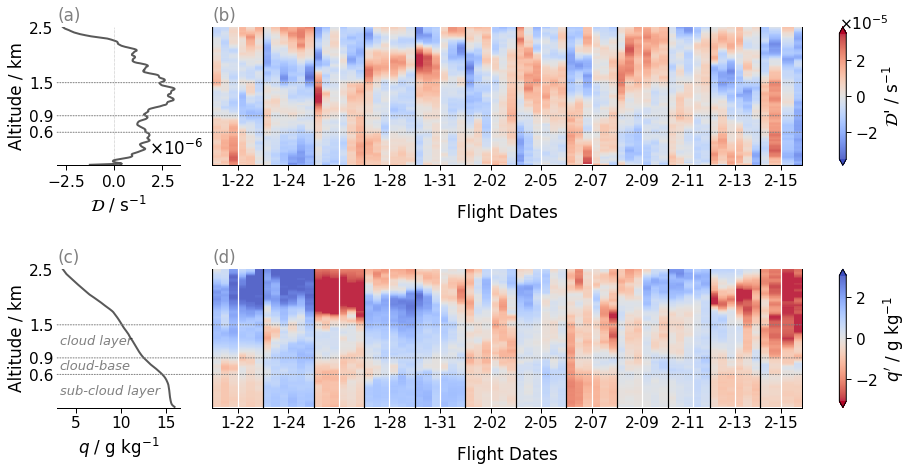

In [23]:
eurec4a_circles['q_1000'] = eurec4a_circles['q']*1000

pars = ['D','q_1000']
cbar_labels = ["$\mathcal{D}$\' / s$^{-1}$","$q\'$ / g kg$^{-1}$"]
mean_xlabels = ["$\mathcal{D}$ / s$^{-1}$","$q$ / g kg$^{-1}$"]

ylim = 2510

sb.set_context('paper',font_scale=1.75)
f,ax = plt.subplots(len(pars),2,figsize=(16,int(3.5*len(pars))),sharey=True, gridspec_kw={'width_ratios': [1,6]})
plt.subplots_adjust(wspace=0.075,hspace=0.75)

titles = list(string.ascii_lowercase)

for i in range(len(pars)) :
    
    if pars[i] == 'D':
        cm = plt.get_cmap('coolwarm').copy()
    else :
        cm = plt.get_cmap('coolwarm_r').copy()
    
    cb = (eurec4a_circles[pars[i]] - eurec4a_circles[pars[i]].mean(
        dim='circle')).plot.pcolormesh(
        y='alt',center=0,robust=True,cmap=cm,ax=ax[i,1],alpha=0.85,add_colorbar=False)

    ax[i,0].plot(eurec4a_circles[pars[i]].sel(alt=slice(0,ylim)).mean(dim='circle'),
                 eurec4a_circles.alt.sel(alt=slice(0,ylim)),linewidth=2,color='k',alpha=0.65)
    
    [ax[i,0].spines[m].set_visible(False) for m in ['right','top','left']]
    if i == 0:
        ax[i,0].axvline(0,color='grey',linestyle=':',linewidth=.5)
    
    pf.sci_exp_axis(ax[i,0],y_pad=0.075)
    
    ax[i,0].set_xlabel("")

    plt.ylim(0,ylim)

    min_circle = min(eurec4a_circles.circle.values)
    axv_ids = []
    days = []


    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel(mean_xlabels[i],labelpad=5)
    ax[i,1].set_xlabel('Flight Dates',labelpad=15)
    
    yticks = np.array([600,900,1500,2500])
    ax[i,1].set_yticks(yticks)
    ax[i,1].set_yticklabels(yticks/1000)
    ax[i,0].set_ylabel("Altitude / km")
    
    [ax[i,m].tick_params(axis='y', which=u'both',length=0) for m in range(2)]
    
    for id_, j in enumerate(eurec4a_circles.circle_time):    

        curr_date = pd.to_datetime(j.values).date()

        if id_ == 0:
            ax[i,1].axvline(min_circle + id_ - 0.5, c="k")
            ax[i,1].axvline(min_circle + id_ + 3 - 0.5, c="w")
            
            axv_ids.append(min_circle + id_ - 0.5)
            days.append(curr_date)
        elif curr_date != prev_date:
            ax[i,1].axvline(min_circle + id_ - 0.5, c="k")
            
            if (datetime.date(2020, 2, 15) == pd.DatetimeIndex(
                [j.values]).date[0]) :
                
                ax[i,1].axvline(min_circle + id_ + 2, c="w")
                
            elif (datetime.date(2020, 1, 24) == pd.DatetimeIndex(
                [j.values]).date[0]):
                pass
            else :
                ax[i,1].axvline(min_circle + id_ + 3 - 0.5, c="w")
            
            axv_ids.append(min_circle + id_ - 0.5)
            days.append(curr_date)
        if j == eurec4a_circles.circle_time.values[-1] :
            axv_ids.append(min_circle + id_ + 1.5)
            days.append(curr_date)

        prev_date = curr_date
        
    xticks = (np.array(axv_ids[1:]) + np.array(axv_ids[:-1]))/2
    xlabels = [
            f"{pd.to_datetime(days[j]).month:01d}-{pd.to_datetime(days[j]).day:02d}"
            for j in range(len(days[:-1]))
        ]

    ax[i,1].set_xticks(xticks)
    ax[i,1].set_xticklabels(xlabels)
    ax[i,1].spines['top'].set_visible(False)

    fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
    cbar = f.colorbar(cb, ax=ax[i,1], orientation="vertical", extend="both",label=cbar_labels[i],format=fmt)
    cbar.ax.yaxis.set_offset_position('left')

    [ax[i,m].set_title(f'({titles[int(i*2 + m)]})',loc='left',weight='light',c='grey') for m in range(2)]
    
    # line over both plots
    xleft, _ = ax[i,0].get_xlim()
    _, xright = ax[i,1].get_xlim()
    
    for ht in [600,900,1500]:
        n_p_border = ConnectionPatch(xyA=(xleft,ht), xyB=(xright,ht), 
                                     coordsA='data', coordsB='data',
                                     axesA=ax[i,0], axesB=ax[i,1], lw=1,linestyle=':',color='grey')
        ax[i,1].add_artist(n_p_border)

ax[1,0].text(ax[1,0].get_xlim()[0]*1.1,300,'sub-cloud layer',fontsize=13,zorder=0,verticalalignment='center',color='grey',fontstyle='italic')
ax[1,0].text(ax[1,0].get_xlim()[0]*1.1,750,'cloud-base',fontsize=13,zorder=0,verticalalignment='center',color='grey',fontstyle='italic')
ax[1,0].text(ax[1,0].get_xlim()[0]*1.1,1200,'cloud layer',fontsize=13,zorder=0,verticalalignment='center',color='grey',fontstyle='italic')

# plt.savefig(f'EUREC4A_all_anomaly_parameters_div_q_upto_{ylim}_custom_yaxis_layers_shown.png',dpi=300,bbox_inches='tight')
# plt.savefig(f'EUREC4A_all_anomaly_parameters_div_q_upto_{ylim}_custom_yaxis_layers_shown.pdf',bbox_inches='tight')